In [1]:
import os
import sys
import glob
import pathlib
import pydicom
import pandas as pd
import numpy as np
import nibabel as nib
import SimpleITK as sitk
import matplotlib.pyplot as plt
import pydicom as pyd
from tqdm import tqdm
from datetime import datetime
import seaborn as sns

os.makedirs('output_Task06', exist_ok=True)
os.makedirs('images', exist_ok=True)

#HOME = os.getenv("HOME")

In [2]:
# Function to set elements in bold
def set_bold_properties(ax):
	ax.title.set_weight('bold')
	ax.xaxis.label.set_weight('bold')
	ax.yaxis.label.set_weight('bold')
	plt.setp(ax.get_xticklabels(), weight='bold')
	plt.setp(ax.get_yticklabels(), weight='bold')

## Checking findings

In [3]:
# Path to the file
data_file_path = os.path.join("input/dados_images_task06.csv")

# Reading the CSV file and converting it into a DataFrame
df_csv_data = pd.read_csv(data_file_path, sep=';')

# Removing whitespace from column names
df_csv_data.columns = df_csv_data.columns.str.strip()

print(df_csv_data.columns.tolist())

df_csv_data.rename(columns={'ID_image': 'ID'}, inplace=True)
df_csv_data.rename(columns={'Shape Image': 'Slices'}, inplace=True)

df_csv_data['LUL'] = df_csv_data['LUL'].astype(float)
df_csv_data['LLL'] = df_csv_data['LLL'].astype(float)
df_csv_data['RUL'] = df_csv_data['RUL'].astype(float)
df_csv_data['RML'] = df_csv_data['RML'].astype(float)
df_csv_data['RLL'] = df_csv_data['RLL'].astype(float)

df_csv_data = df_csv_data.drop(columns=['Shape Label'], errors='ignore')

df = df_csv_data.copy(deep=True)

df.head()

['ID_image', 'SliceThickness', 'Shape Image', 'Shape Label', 'Spacing', 'LUL', 'LLL', 'RUL', 'RML', 'RLL']


,ID,SliceThickness,Slices,Spacing,LUL,LLL,RUL,RML,RLL
0,lung_001,1.000000,304,"1.000,0.693,0.693",0.001,0.003,0.006,0.001,0.011
1,lung_002,1.250000,269,"1.250,0.898,0.898",0.000,0.000,0.005,0.004,0.007
2,lung_003,1.245660,288,"1.246,0.938,0.938",0.002,0.027,0.005,0.007,0.005
3,lung_004,1.245471,276,"1.245,0.828,0.828",0.010,0.002,0.034,0.001,0.008
4,lung_005,1.000000,329,"1.000,0.654,0.654",0.008,0.011,0.005,0.056,0.009


In [4]:
import pandas as pd

# Path to the file
file_path = os.path.join("input/medseg_run_statistics_task06.csv")

# Reading the CSV file and converting it into a DataFrame
df_csv = pd.read_csv(file_path)
df_csv.columns = df_csv.columns.str.strip()

df_csv = df_csv.drop(columns=['Path'])

df_csv.rename(columns={'ID_image': 'ID'}, inplace=True)
df_csv['ID'] = df_csv['ID'].astype(str)

# Merging the column from table B into table A based on the 'ID' column' column from table B into table A based on the 'id' column
resulting_table = pd.merge(df_csv, df_csv_data, on='ID')
resulting_table = resulting_table.drop(resulting_table.columns[9], axis=1)

resulting_table = pd.merge(df, df_csv[['ID', 'POI (%)']], on='ID')
resulting_table = pd.merge(resulting_table, df_csv[['ID', 'Voxel volume (mm³)']], on='ID')

df_sorted =  resulting_table.copy(deep=True)
df_sorted.head()

,ID,SliceThickness,Slices,Spacing,LUL,LLL,RUL,RML,RLL,POI (%),Voxel volume (mm³)
0,lung_001,1.000000,304,"1.000,0.693,0.693",0.001,0.003,0.006,0.001,0.011,0.47,4.807472e-07
1,lung_002,1.250000,269,"1.250,0.898,0.898",0.000,0.000,0.005,0.004,0.007,0.32,1.008988e-06
2,lung_003,1.245660,288,"1.246,0.938,0.938",0.002,0.027,0.005,0.007,0.005,0.86,1.094818e-06
3,lung_004,1.245471,276,"1.245,0.828,0.828",0.010,0.002,0.034,0.001,0.008,1.19,8.541328e-07
4,lung_005,1.000000,329,"1.000,0.654,0.654",0.008,0.011,0.005,0.056,0.009,1.03,4.281044e-07


In [5]:
# Defining the intervals for categorization
bins = [-float('inf'),1,5,25,50,75,float('inf')]
labels = [0,1,2,3,4,5]

df_sorted['LUL'] = df_sorted['LUL']*100
df_sorted['LLL'] = df_sorted['LLL']*100
df_sorted['RUL'] = df_sorted['RUL']*100
df_sorted['RML'] = df_sorted['RML']*100
df_sorted['RLL'] = df_sorted['RLL']*100

lobes = ['LUL','LLL','RUL','RML','RLL']

for lobe in lobes:
	# Creating a new column with the categories
	df_sorted['PI_'+str(lobe)] = pd.cut(df_sorted[lobe],
						bins=bins,
						labels=labels,
						include_lowest=True)

	# Sorting the DataFrame first by category and then by the findings value
	df_sorted = df_sorted.sort_values(['PI_'+str(lobe), lobe])

	# Calculating statistics by category
	category_statistics = df_sorted.groupby('PI_'+str(lobe), observed=False).agg({
		lobe: ['count', 'mean', 'min', 'max']
	}).round(2)

	# Resetting the index for better visualization
	df_sorted = df_sorted.reset_index(drop=True)

	#print("Original DataFrame Categorized and Sorted:")
	#print(df_sorted)
	#print("\nStatistics by PI:")
	#print(category_statistics)

df_sorted['PI_LUL'] = df_sorted['PI_LUL'].astype(float)
df_sorted['PI_LLL'] = df_sorted['PI_LLL'].astype(float)
df_sorted['PI_RUL'] = df_sorted['PI_RUL'].astype(float)
df_sorted['PI_RML'] = df_sorted['PI_RML'].astype(float)
df_sorted['PI_RLL'] = df_sorted['PI_RLL'].astype(float)

df_sorted['Score'] = df_sorted[['PI_LUL', 'PI_LLL', 'PI_RUL', 'PI_RML', 'PI_RLL']].sum(axis=1)

# Defining the intervals for categorization
bins_score = [-1, 0, 7, 17, float('inf')]
labels_score = ['No Lesion', 'Mild', 'Moderate', 'Severe']

# Creating a new column with the categories
df_sorted['CategoryScore'] = pd.cut(df_sorted['Score'],
						bins=bins_score,
						labels=labels_score,
						include_lowest=True)

# Sorting the DataFrame first by category and then by the findings value
df_sorted = df_sorted.sort_values(['CategoryScore', 'Score'])

# Calculating statistics by category
category_statistics = df_sorted.groupby('CategoryScore', observed=False).agg({
	'Score': ['count', 'mean', 'min', 'max']
}).round(2)

# Resetting the index for better visualization
df_sorted = df_sorted.reset_index(drop=True)

#print("Original DataFrame Categorized and Sorted:")
#print(df_sorted)
print("\nStatistics by  CategoriaScore:")
print(category_statistics)

# Example of how to filter by a specific category
#specific_category = df_sorted[df_sorted['CategoryScore'] == 'Severe']
#print("\nRecords in the critical category:")
#print(specific_category)


Statistics by  CategoriaScore:
              Score                
              count  mean  min  max
CategoryScore                      
No Lesion         6  0.00  0.0  0.0
Mild             23  3.17  1.0  7.0
Moderate          1  8.00  8.0  8.0
Severe            0   NaN  NaN  NaN


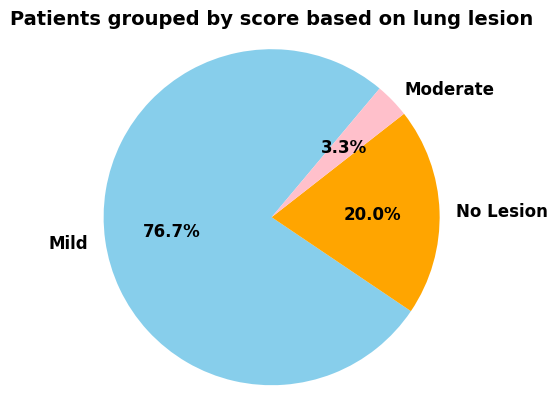

In [6]:
# Count the number of patients grouped by score
categoriaScore_counts = df_sorted['CategoryScore'].value_counts()

# Remove empty categories (NaN or zero values)
categoriaScore_counts = categoriaScore_counts[categoriaScore_counts > 0]

# Create the pie chart
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(
	categoriaScore_counts,
	labels=categoriaScore_counts.index,
	autopct='%1.1f%%',
	startangle=50,
	colors=['skyblue', 'orange', 'pink', 'magenta'],
	textprops={'fontweight': 'bold', 'fontsize': 12}
)

# Set the texts inside the sectors (autotexts)
for autotext in autotexts:
	autotext.set_fontweight('bold')
	autotext.set_color('black')
	autotext.set_fontsize(12)

# Chart settings
ax.set_title('Patients grouped by score based on lung lesion', fontsize=14, fontweight='bold')
ax.axis('equal')  # Ensure the chart is circular

# Display the chart
plt.savefig("images/patientes_grouped_score_task06.eps", dpi=200, format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


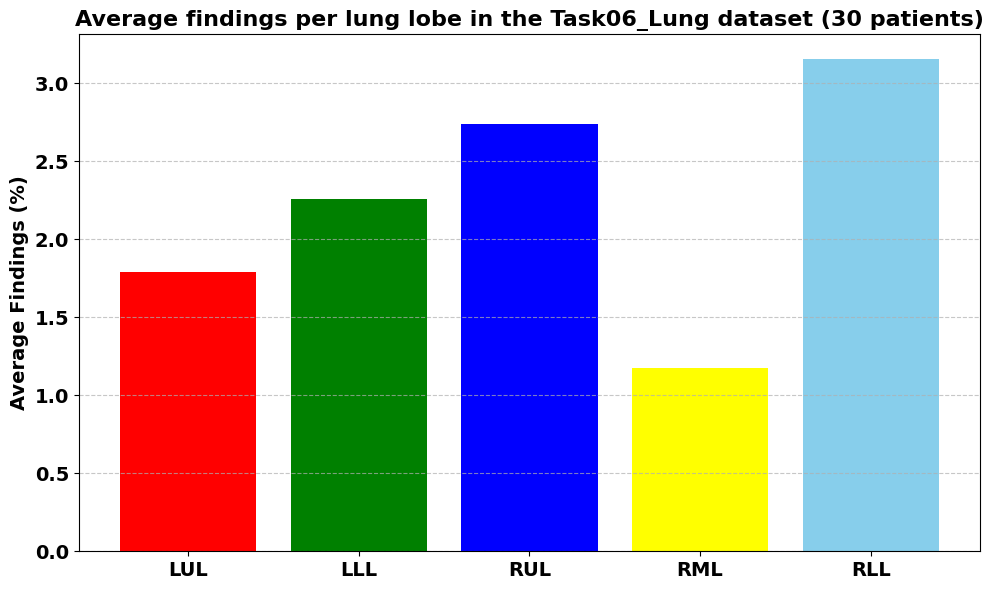

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Calculate the mean of the findings per lobe
lobos = ['LUL', 'LLL', 'RUL', 'RML', 'RLL']
average_findings = df_sorted[lobos].mean()

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(average_findings.index, average_findings, color=['red', 'green', 'blue', 'yellow', 'skyblue'])

# Customize the chart
plt.title('Average findings per lung lobe in the Task06_Lung dataset (30 patients)', fontsize=16, fontweight='bold')
plt.ylabel('Average Findings (%)', fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')

# Display the chart
plt.tight_layout()
plt.savefig("images/findings_per_lobe_cancer.eps", dpi=200, format='eps')
plt.show()

In [8]:
df_sorted = df_sorted.drop(columns=['PI_LUL', 'PI_LLL', 'PI_RUL', 'PI_RML', 'PI_RLL'])

df_sorted.rename(columns={'ID': 'ID Image'}, inplace=True)
df_sorted.rename(columns={'Resolution': 'Slices'}, inplace=True)

df_sorted['Slices'] = df_sorted['Slices'].astype(int)

df_sorted['LUL'] = df_sorted['LUL'].apply(lambda x: round(x, 1))
df_sorted['LLL'] = df_sorted['LLL'].apply(lambda x: round(x, 1))
df_sorted['RUL'] = df_sorted['RUL'].apply(lambda x: round(x, 1))
df_sorted['RML'] = df_sorted['RML'].apply(lambda x: round(x, 1))
df_sorted['RLL'] = df_sorted['RLL'].apply(lambda x: round(x, 1))

output_csv = "output_Task06/dicom_headers_Task06_final.csv"
df_sorted.to_csv(output_csv, index=False)
print(f"Table saved in {output_csv}")

Table saved in output_Task06/dicom_headers_Task06_final.csv
